# Molecular dynamics in SchNetPack

In the [previous tutorial](tutorial_03_force_models.ipynb) we have covered how to train machine learning (ML) models on molecular forces and use them for basic molecular dynamics (MD) simulations with the SchNetPack ASE interface.

All these simulations can also be carried out using the native MD package available in SchNetPack.
The main ideas behind integrating MD functionality directly into SchNetPack are:
- improve performance by reducing the communication overhead between ML models and the MD code and adding the option to use GPUs
- adding extended functionality, such as sampling algorithms (e.g. constant temperature or pressure) and ring polymer MD
- providing a modular MD environment for easy development and interfacing

In the following, we first introduce the general structure of the SchNetPack-MD package.
Then the simulation from the previous tutorial will be used as an example to demonstrate how to implement basic MD with SchNetPack-MD.
Having done so, we will cover a few advanced simulation techniques, such as ring polymer MD.

Finally, we will show how all of these different simulations can be accessed via the `hydra` CLI and config files.

## Getting started

Before we can begin with the main tutorial, some setup is required.
First, we generate a directory in which the simulations will be carried out:

In [1]:
import os

md_workdir = 'mdtut'

# Gnerate a directory of not present
if not os.path.exists(md_workdir):
    os.mkdir(md_workdir)

Since we want to run MD simulations, we need a SchNetPack model trained on forces and a molecular structure as a starting point.
In principle, we could use the ethanol model and structure generated in the previous tutorial.
However, the model trained in the force tutorial was only intended as a demonstration and is not the most accurate.


Instead, we will use a sample ethanol structure, as well as a fully converged PaiNN model of ethanol provided in `schnetpack/tests/data` for this tutorial:

In [2]:
import schnetpack as spk

# Get the parent directory of SchNetPack
spk_path = os.path.abspath(os.path.join(os.path.dirname(spk.__file__), '../..'))

# Get the path to the test data
test_path = os.path.join(spk_path, 'tests/data')

# Load model and structure
model_path = os.path.join(test_path, 'md_ethanol.model')
molecule_path = os.path.join(test_path, 'md_ethanol.xyz')

## MD in SchNetPack

In general, a MD code needs to carry out several core tasks during each simulation step. 
It has to keep track of the positions $\mathbf{R}$ and momenta $\mathbf{p}$ of all nuclei, compute the forces $\mathbf{F}$ acting on the nuclei and use the latter to integrate Newton's equations of motion.

<img src="tutorials_figures/md_flowchart.svg" width="200" style="padding: 5px 15px; float: left;">

The overall workflow used in the SchNetPack-MD package is sketched in the figure above.
As can be seen, the various tasks are distributed between different modules:

 - The `System` class contains all information on the present state of the simulated system (e.g. nuclear positions and momenta).
 - The `Integrator` computes the positions and momenta of the next step and updates the state of the system accordingly.
 - In order to carry out this update, the nuclear forces are required. These are computed with a `Calculator`, which takes the positions of atoms and returns the corresponding forces. Typically, the `Calculator` consists of a previously trained machine learning model.

All these modules are linked together in the `Simulator` class, which contains the main MD loop and calls the three previous modules in the correct order.

We will now describe the different components of the MD package in more detail and give an example of how to set up a short MD simulation of an ethanol molecule.

### System

As stated previously, `System` keeps track of the state of the simulated system and contains the atomic positions $\mathbf{R}$ and momenta $\mathbf{p}$, but also e.g. atom types, simulation cells and computed molecular properties.

A special property of SchNetPack-MD is the use of multidimensional tensors to store the system information (using the `torch.Tensor` class).
This makes it possible to make full use of vectorization and e.g. simulate several different molecules as well as different replicas of a molecule in a single step.
The general shape of these system tensors is similar to the structure used in the SchNetPack models: $N_\textrm{replicas} \times (N_\textrm{molecules} \cdot N_\textrm{atoms}) \times \ldots$, where the first dimension is the number of replicas of the same molecule (e.g. for ring polymer MD) and the second runs over the atoms of all molecules. This removes the need for extensive zero-padding  and masking when simulating molecules of different sizes.

To prepare a system for simulation, first an empty instance of the `System` class is created.
Afterwards, the molecules which should be simulated need to be loaded via `load_molecules`.
This function takes `ase.Atoms` objects as inputs, which can be created from all file formats supported by ASE with the `ase.io.read` function.
Here, we use an XYZ file containing the structure of a single ethanol.
If a list of `Atoms` objects is provided to `load_molecules`, multiple molecules can be loaded at once.
Next, the number of replicas used during MD needs to be given. For a standard MD $N_\mathrm{replicas}=1$.
Finally, the units of length used in the input structures needs to be provided, in this case `Angstrom`.
This is necessary, since the MD code uses its own unit system internally and inputs are converted automatically.
(If atomic masses are to be loaded from the input files, a unit of mass also needs to be provided. By default, Daltons are assumed.)

In [3]:
from schnetpack.md import System
from ase.io import read

# Load atoms with ASE
molecule = read(molecule_path)

# Number of molecular replicas
n_replicas = 1

# Create system instance and load molecule
md_system = System()
md_system.load_molecules(
    molecule,
    n_replicas,
    position_unit_input="Angstrom"
)

/home/mitx/anaconda3/envs/spk_dev/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Right now, all system momenta are set to zero.
For practical purposes, one usually wants to draw the momenta from a distribution corresponding to a certain temperature.
This can be done with an `Initializer`, which takes the temperature in Kelvin as an input.
For this example, we use `UniformInit` which draws all momenta from a random uniform distribution and rescales them to a certain temperature.
Other routines, e.g. drawing from a Maxwell&mdash;Boltzmann distribution, are also available.


In [4]:
from schnetpack.md import UniformInit

system_temperature = 300 # Kelvin

# Set up the initializer
md_initializer = UniformInit(
    system_temperature,
    remove_center_of_mass=True,
    remove_translation=True,
    remove_rotation=True,
)

# Initialize the system momenta
md_initializer.initialize_system(md_system)

The `Initializer` can also be used to center the moleculer structure on the center of mass and remove all translational and rotational components of the momenta, as was done in the code snippet above.

### Integrator

Having set up the system in such a manner, one needs to specify how the equations of motion should be propagated.
Currently, there are two integration schemes implemented in SchNetPack:
- a Velocity Verlet integrator which evolves the system in a purely classical manner and
- a ring polymer integrator which is able to model a certain degree of nuclear quantum effects

For demonstration purposes, we will first focus on a purely classical MD using the Velocity Verlet algorithm.
An example on how to use ring polymer MD in SchNetPack and potential benefits will be given later in the tutorial.
To initialize the integrator, one has to specify the length of the timestep $\Delta t$ used for integration in units of femtoseconds.
A common value for classical MD is $\Delta t = 0.5$&thinsp;fs.


In [5]:
from schnetpack.md.integrators import VelocityVerlet

time_step = 0.5 # fs

# Set up the integrator
md_integrator = VelocityVerlet(time_step)

### Calculator

The only ingredient missing for simulating our system is a `Calculator` to compute molecular forces and other properties.
A `Calculator` can be thought of as an interface between a computation method (e.g. a machine learning model) and the MD code in SchNetPack.
SchNetPack comes with several predefined calculators and also offers the possibility to implement custom calculators.

Right now, we are only interested in using a model trained with SchNetPack, hence we use the `SchNetPackCalculator`.
To initialize the `SchNetPackCalculator`, two steps are required.

First, we have to define a neighbor list which computes interatomic distances during the MD.
This is done with the `NeighborListMD` wrapper, which can set up any SchNetPack neighbor list transform to be suitable for simulations.
The required arguments are a cutoff radius and buffer region (both use the same length units as the model).
Using a buffer region has the advantage, that neighbor lists only needs to be recomputed from scratch once the atoms move a certain distance.
Here, we use a cutoff of 5 &Aring;, a buffer of 2 &Aring; and the `ASENeigborList` as basic neighbor list:

In [6]:
from schnetpack.md.neighborlist_md import NeighborListMD
from schnetpack.transform import ASENeighborList

# set cutoff and buffer region
cutoff = 5.0  # Angstrom (units used in model)
cutoff_shell = 2.0  # Angstrom

# initialize neighbor list for MD using the ASENeighborlist as basis
md_neighborlist = NeighborListMD(
    cutoff,
    cutoff_shell,
    ASENeighborList,
)

In a second step, the `Calculator` needs to be set up.
Similar as for the ASE interface in the [last tutorial](tutorial_03_force_models.ipynb), we have to tell the calculator the path to a stored model and how the forces are labeled in the output.
It is also necessary to specify which units the calculator expects for positions and for the energy.
Force units are converted automatically based on these two inputs.
Optionally, one can also provide an `energy_label` to store the potential energies in the `System` class if returned by the model.
Additional properties (e.g. dipole moments, etc.) can be requested with the `required_properties` argument.

Here, we use the pretrained model defined above.
Since it is a SchNetPack model, we can use SchNetPack property definitions for force (and energy) labels.
With regard to units, the current calculator uses &Aring; for positions and kcal/mol; for the energies.
The conversion factors can either be given as a number or as a string (please use `Angstrom` or `Ang` for &Aring;, since `A` would indicate Ampere).

In [7]:
from schnetpack.md.calculators import SchNetPackCalculator
from schnetpack import properties

md_calculator = SchNetPackCalculator(
    model_path,  # path to stored model
    "forces",  # force label
    "kcal/mol",  # energy units
    "Angstrom",  # length units
    md_neighborlist,  # neighbor list
    energy_label="energy",  # label for potential energies
    required_properties=[],  # additional properties extracted from the model
)

INFO:schnetpack.md.calculators.schnetpack_calculator:Loading model from /home/mitx/Projects/schnetpack_v2/schnetpack/tests/data/md_ethanol.model
INFO:schnetpack.md.calculators.schnetpack_calculator:Deactivating inference mode for simulation...
INFO:schnetpack.md.calculators.schnetpack_calculator:Found `AddOffsets` postprocessing module...
INFO:schnetpack.md.calculators.schnetpack_calculator:Constant offset of   -10799.55122728765 will be removed...


### Simulator (bringing it all together)

With our molecular system, a machine learning calculator for the forces and an integrator at hand, we are almost ready to carry out a MD simulation.
The last step is to pass all these ingredients to a `Simulator`.
The `Simulator` performs the actual MD simulations, looping over a series of time steps and calling the individual modules in the appropriate order:

In [8]:
from schnetpack.md import Simulator

md_simulator = Simulator(
    md_system,
    md_integrator,
    md_calculator
)

Before starting the actual simulation, it is also recommended to set the desired floating point precision and computational device:

In [9]:
import torch

# check if a GPU is available and use a CPU otherwise
if torch.cuda.is_available():
    md_device = "cuda"
else:
    md_device = "cpu"

# use single precision
md_precision = torch.float32

# set precision
md_simulator = md_simulator.to(md_precision)
# move everything to target device
md_simulator = md_simulator.to(md_device)

To finally carry out the simulation, one needs to call the `simulate` function with an integer argument specifying the number of simulation steps.

For example, a MD simulation of our ethanol molecule for 100 time steps (50&thinsp;fs) can be done via:

In [10]:
n_steps = 100

md_simulator.simulate(n_steps)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 52.69it/s]


Since the `Simulator` keeps track of the state of the dynamics and the system, we can call it repeatetly to get longer trajectories.

In [11]:
md_simulator.simulate(n_steps)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 81.82it/s]


The actual number of steps is stored in the `step` variable of the `Simulator` class.

In [12]:
print("Total number of steps:", md_simulator.step)

Total number of steps: 200


Although we are now able to run a full-fledged MD simulation, there is one major problem with the current setup:
we do not collect any information during the simulation, such as nuclear positions.
This means, that we currently have no way of analyzing what happened during the MD trajectory.


This &mdash; and many other things &mdash; can be done in the SchNetPack-MD package using so-called simulation hooks.



## Simulation hooks


Simulation hooks can be thought as instructions for the `Simulator`, which are performed at certain points during each MD step.
They can be used to tailor a simulation to specific needs, contributing to the customizability of the SchNetPack-MD package.

<img src="tutorials_figures/integrator.svg" width="370" style="padding: 20px 20px; float: left">

The diagram above shows how a single MD step of the `Simulator` is structured in detail and at which points hooks can be applied.
Depending on which time they are called and which actions they encode, simulation hooks can achieve a wide range of tasks.

If they are introduced before and after each integration half-step, they can e.g. be used to control the temperature of the system in the form of thermostats.

When acting directly after the computation of the forces done by the `Calculator`, simulation hooks can be used to control sampling.
At this point, enhanced sampling schemes such as metadynamics and accelerated MD can be implemented, which modify the forces and potential energies of the system.
It is also possible to introduce active learning for automatically generating machine learning models in this way.

Finally, when called after the second integration step, simulation hooks can be used to collect and store information on the system, which can then be used for analysis.

Multiple hooks can be passed to a simulator at any time, which makes it possible to control a simulation in various manners.
In the following, we will demonstrate how to apply a thermostat to the above simulation and how data can be collected.

### Adding a Thermostat

As mentioned in the [force tutorial](tutorial_03_force_models.ipynb), thermostats are used to keep the fluctuations of the kinetic energy of a system (temperature) close to a predefined average.
Simulations employing thermostats are referred to as canonical ensemble or $NVT$ simulations, since they keep the number of particles $N$, the volume $V$ and the average temperature $T$ constant.

Last time, we used a Langevin thermostat to regulate the temperature of our simulation.
This thermostat (and many others) is also available in SchNetPack and can be used via

In [13]:
from schnetpack.md.simulation_hooks import LangevinThermostat

# Set temperature and thermostat constant
bath_temperature = 300  # K
time_constant = 100  # fs

# Initialize the thermostat
langevin = LangevinThermostat(bath_temperature, time_constant)

In case of the Langevin thermostat, a bath temperature (in Kelvin) and a time constant (in fs) have to be provided.
The first regulates the temperature the system is kept at, the second how fast the thermostat adjusts the temperature. 
In order to speed up equilibration, we use a more aggressive thermostatting schedule by with a time constant of 100&thinsp;fs.

Finally, we begin collecting the simulation hooks we want to pass to the simulator.

In [14]:
simulation_hooks = [
    langevin
]

### Collecting Data

The primary way to store simulation data in the SchNetPack-MD package is via the `FileLogger` class.
A `FileLogger` collects data during the MD and stores it to a database in HDF5 format.
The type of data to be collected is specified via so-called `DataStreams`, which are passed to the `FileLogger`.
The data streams currently available in SchNetPack are:

- `MoleculeStream`: Stores positions and velocities during all simulation steps
- `PropertyStream`: Stores properties predicted by the calculator (no unit conversion is performed unless requested)

To reduce overhead due to writing to disk, the `FileLogger` first collects information for a certain number of steps into a buffer, which it then writes to the database at once.

The `FileLogger` is initialized by specifying the name of the target database, the size of the buffer and which data to store (in form of the respective data streams). In addition, logging frequency and floating point precision can be specified:

In [15]:
from schnetpack.md.simulation_hooks import callback_hooks

# Path to database
log_file = os.path.join(md_workdir, "simulation.hdf5")

# Size of the buffer
buffer_size = 100

# Set up data streams to store positions, momenta and the energy
data_streams = [
    callback_hooks.MoleculeStream(store_velocities=True),
    callback_hooks.PropertyStream(target_properties=[properties.energy]),
]

# Create the file logger
file_logger = callback_hooks.FileLogger(
    log_file,
    buffer_size,
    data_streams=data_streams,
    every_n_steps=1,  # logging frequency
    precision=32,  # floating point precision used in hdf5 database
)

# Update the simulation hooks
simulation_hooks.append(file_logger)

### Storing checkpoints

In general, it is also a good idea to store checkpoints of the system and simulation state at regular intervals.
Should something go wrong, these can be used to restart the simulation from the last stored point.
In addition, checkpoints can also be used to initialize the `System` to a certain state.
This is e.g. useful for equilibrating simulations with different thermostats.

Storing checkpoints can be done with the `Checkpoint` hook, which takes a file the data is stored to and the frequency a checkpoint is generated:

In [16]:
#Set the path to the checkpoint file
chk_file = os.path.join(md_workdir, 'simulation.chk')

# Create the checkpoint logger
checkpoint = callback_hooks.Checkpoint(chk_file, every_n_steps=100)

# Update the simulation hooks
simulation_hooks.append(checkpoint)

### Monitoring the simulation with TensorBoard

It is also possible to directly monitor simulations with a `TensorBoardLogger`.
This callback collects various properties and stores them to log file that can be viewed with TensorBoard.
Different properties can be specified via keywords:

- `energy`: log kinetic and potential energies.
- `temperature`: log the system temperature.
- `pressure`: log the pressure during NPT simulations.
- `volume`: log cell volumes during NPT simulations.

E.g., to monitor potential and kinetic energies, as well as the temperature, the following setup can be used:

In [17]:
# directory where tensorboard log will be stored to
tensorboard_dir = os.path.join(md_workdir, 'logs')

tensorboard_logger = callback_hooks.TensorBoardLogger(
    tensorboard_dir,
    ["energy", "temperature"], # properties to log
)

# update simulation hooks
simulation_hooks.append(tensorboard_logger)

The simulation progress of the different properties can then be viewed in TensorBoard via

    tensorboard --logdir=mdtut/logs

### Adding hooks and running the simulation

With all simulation hooks created and collected in `simulation_hooks`, we can finally build our updated simulator.
This is done exactly the same way as above, with the difference that now the hooks are specified as well.

In [18]:
md_simulator = Simulator(md_system, md_integrator, md_calculator, simulator_hooks=simulation_hooks)

md_simulator = md_simulator.to(md_precision)
md_simulator = md_simulator.to(md_device)

We can now use the simulator to run a MD trajectory of our ethanol. Here, we run for 20000 steps, which are 10&thinsp;ps.
This should take approximately 5 minutes on a notebook GPU.

In [19]:
n_steps = 20000

md_simulator.simulate(n_steps)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [03:27<00:00, 96.45it/s]


After the simulation, the tutorial directory should contain the following entries:
- `simulation.hdf5` holding the collected data
- `simulation.chk` containing the last checkpoint and
- `logs` which contains the TensorBoard log files.

## Reading HDF5 outputs

We will now show, how to access the HDF5 files generated during the simulation.
For this purpose, SchNetPack comes with a `HDF5Loader`, which can be used to extract the data by giving the path to the simulation output (`mdtut/simulation.hdf5`).

In [20]:
from schnetpack.md.data import HDF5Loader

data = HDF5Loader(log_file)

INFO:schnetpack.md.data.hdf5_data:Loaded properties _atomic_numbers, masses, energy_system, _positions, velocities, _cell and energy from mdtut/simulation.hdf5


Extracted data is stored in the `properties` dictionary of the `HDF5Loader` and can be accessed with the `get_property` function.
Right now, we can access the following entries, most of which should be self explaining and correspond to the standard SchNetPack `properties` keys:

In [21]:
for prop in data.properties:
    print(prop)

_atomic_numbers
masses
energy_system
_positions
velocities
_cell
energy


`masses` are the atomic masses in Dalton. The two energies `energy` and `energy_system` are present, since we a) requested the energy from the `Calculator` to be stored as the potential energy of `System` with the `energy_label` keyword and b) we requested the `energy` property to be logged in the `PropertyStream` of the `FileLogger`. The difference between both quantities is that the former uses SchNetPack internal units (kJ/mol) while the latter uses the `Calculator`'s units (kcal/mol). While logging both is not necessary for practical purposes, it serves as an example for the different ways to log quantities during simulations.

### Extracting basic properties

We can use both potential energies to show how properties can be extracted from the HDF5 file in different ways.
As stated above, one way is to use the `get_property` function.
It requires the name of the property and the information whether the property is atomistic (entries for every single atom, e.g. forces) or not (e.g. energies).
Optionally, the index of the molecule and replica for which the data should be extracted can also be provided.
By default, `get_property` extracts the first molecule (`mol_idx=0`) and averages over all replicas if more than one are present.
Neither is relevant for our current simulation.

Alternatively, there are several hardcoded functions to retrieve specific properties from the logged system information (e.g. temperature, kinetic energy, etc.).
Here, we use the `get_potential_energy` function to directly access the system potential energy (`energy_system`).
Shown are the last 200 fs of the trajectory.

Shape: (20000,)


<IPython.core.display.Javascript object>


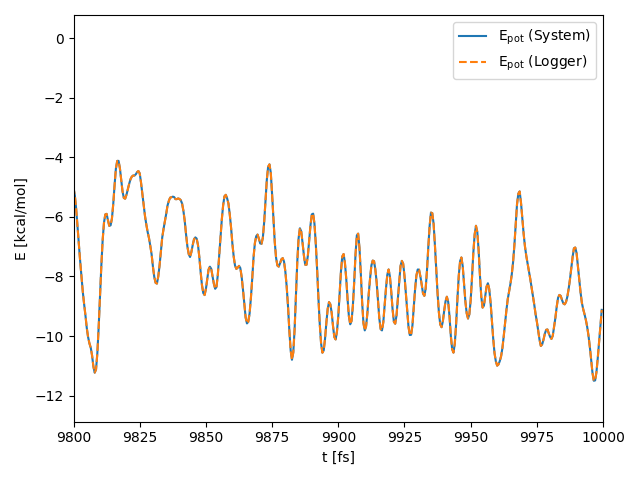

In [22]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from schnetpack import units as spk_units


# Get the energy logged via PropertiesStream
energies_calculator = data.get_property(properties.energy, atomistic=False)
# Get potential energies stored in the MD system
energies_system = data.get_potential_energy()

# Check the overall shape
print("Shape:", energies_system.shape)

# Get the time axis
time_axis = np.arange(data.entries) * data.time_step / spk_units.fs  # in fs

# Convert the system potential energy from internal units (kJ/mol) to kcal/mol
energies_system *= spk_units.convert_units("kJ/mol", "kcal/mol")

# Plot the energies
plt.figure()
plt.plot(time_axis, energies_system, label="E$_\mathrm{pot}$ (System)")
plt.plot(time_axis, energies_calculator, label="E$_\mathrm{pot}$ (Logger)", ls="--")
plt.ylabel("E [kcal/mol]")
plt.xlabel("t [fs]")
plt.xlim(9800,10000)
plt.legend()
plt.tight_layout()
plt.show()

As would be expected, once the energy stored in the `System` class has been converted from MD internal units to kcal/mol with the `convert_units` function, both curves are identical.

The functions provided by the `HDF5Loader` also offer access to a number of derived properties, such as the kinetic energy (`get_kinetic_energy`), the temperature (`get_temperature`) or the pressure (`get_pressure`).

Since we performed a NVT simulation, it makes sense to inspect the temperature for our example.

<IPython.core.display.Javascript object>


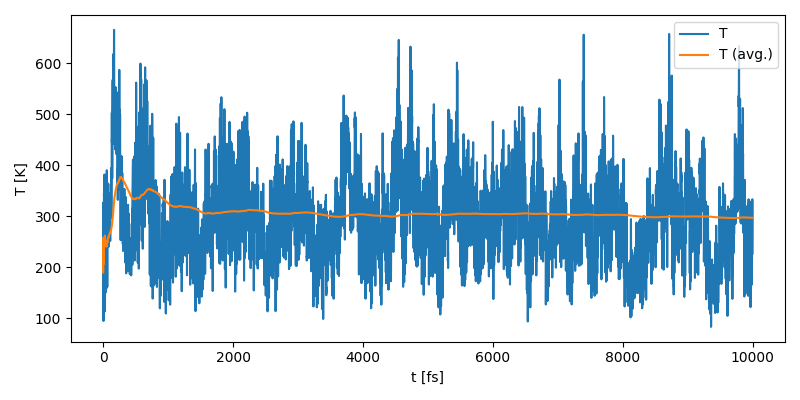

In [23]:
import numpy as np

def plot_temperature(data):

    # Read the temperature
    temperature = data.get_temperature()

    # Compute the cumulative mean
    temperature_mean = np.cumsum(temperature) / (np.arange(data.entries)+1)

    # Get the time axis
    time_axis = np.arange(data.entries) * data.time_step / spk_units.fs  # in fs

    plt.figure(figsize=(8,4))
    plt.plot(time_axis, temperature, label='T')
    plt.plot(time_axis, temperature_mean, label='T (avg.)')
    plt.ylabel('T [K]')
    plt.xlabel('t [fs]')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_temperature(data)

As can be seen, the system requires an initial period for equilibration.
This is relevant for simulations, as ensemble properties are typically only computed for fully equilibrated systems.

In SchNetPack, the equilibration period can be accounted for in different ways.
The checkpoint file of the equilibrated system can be used as a starting point for a production simulation.
The easier way is to reject the initial part of the trajectory and only consider the equilibrated system for analysis.
This can be done by specifying the number of steps to skip in the `HDF5Loader`. 
Here, we skip the first half (10&thinsp;000 steps) of the trajectory.
In general, the equilibration period strongly depends on system size and the thermostat settings.

In [24]:
equilibrated_data = HDF5Loader(log_file, skip_initial=10000)

INFO:schnetpack.md.data.hdf5_data:Loaded properties _atomic_numbers, masses, energy_system, _positions, velocities, _cell and energy from mdtut/simulation.hdf5


We can easily see, that only the later part of the simulation is now considered by plotting the data once again:

<IPython.core.display.Javascript object>


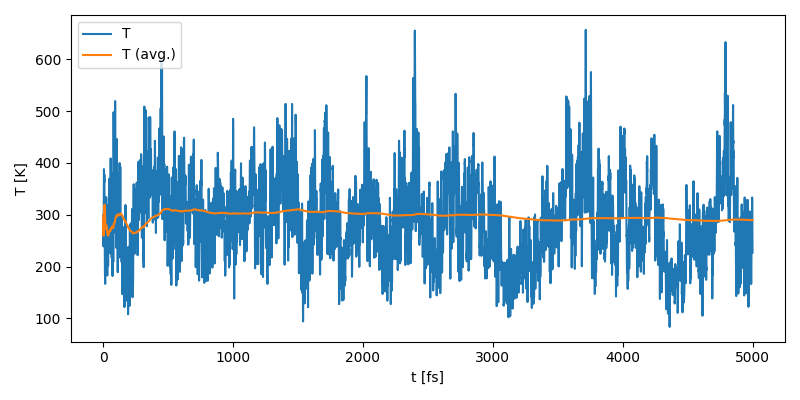

In [25]:
plot_temperature(equilibrated_data)

As stated before, the HDF5 datafile uses a special convention for units.
For internal quantities (e.g. positions, velocities and kinetic energy), internal MD units are used (based on kJ/mol, nm and Dalton).
The only exception are temperatures, which are given in units of Kelvin for convenience.
For all properties computed by the `Calculator` the original unit returned by the model is used, unless a conversion factor is specified during initialization.
This means, that the energies and forces collected here have units of kcal/mol and kcal/mol/&Aring;.

### Extracting structures

Structures can be extracted from the HDF5 database with the `convert_to_atoms` function.
It returns a list of ASE `Atoms` objects of all sampled configurations.
These can then e.g. be used to store the trajectory in XYZ file format using the `ase.io.write` utilities:


In [26]:
from ase.io import write

# extract structure information from HDF5 data
md_atoms = data.convert_to_atoms()

# write list of Atoms to XYZ file
write(
    os.path.join(md_workdir, "trajectory.xyz"),
    md_atoms,
    format="xyz"
)

INFO:schnetpack.md.data.hdf5_data:Extracting structures...
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:02<00:00, 7423.71it/s]


### Vibrational spectra

While curves of temperatures and wobbling atoms might be nice to look at, one is usually also interested in other quantities when running a MD simulation.
One example are vibrational spectra, which give information on which vibrations are active in a molecule.
SchNetPack provides the module `schnetpack.md.data.spectra`, which contains different classes for computing vibrational spectra directly from the HDF5 files.
These implementations use several tricks to improve efficiency and accuracy.
Currently, power spectra (`PowerSpectrum`), infrared (IR) spectra (`IRSpectrum`) and Raman Spectra (`RamanSpectrum`) are available.

Here, we will compute the power spectrum from our ethanol simulation:

In [27]:
from schnetpack.md.data import PowerSpectrum

# Initialize the spectrum
spectrum = PowerSpectrum(equilibrated_data, resolution=2048)

# Compute the spectrum for the first molecule (default)
spectrum.compute_spectrum(molecule_idx=0)

INFO:root:Spectral resolutions:        4.072 [cm^-1]
INFO:root:Spectral range:          33356.410 [cm^-1]


The `resolution` keyword specifies, how finely the peaks in the spectrum are resolved.
`PowerSpectrum` also computes the effective resolution in inverse centimeters, as well as the spectral range.
For molecules, one is usually interested in frequencies up to 4000&thinsp;cm<sup>-1</sup>, which we will use to restrict the plotting area.


<IPython.core.display.Javascript object>


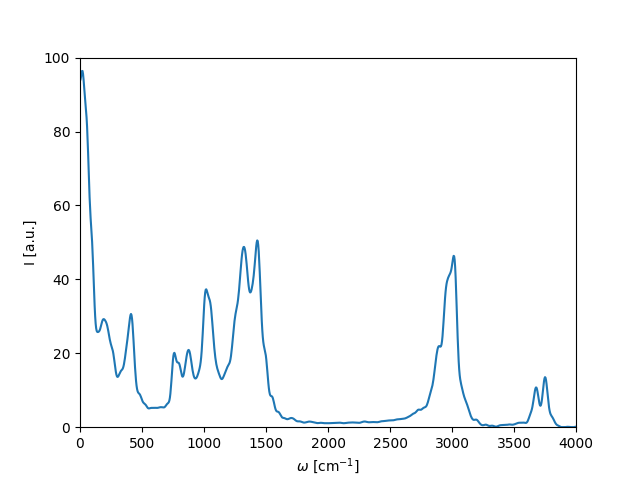

In [28]:
# Get frequencies and intensities
frequencies, intensities = spectrum.get_spectrum()

# Plot the spectrum
plt.figure()
plt.plot(frequencies, intensities)
plt.xlim(0,4000)
plt.ylim(0,100)
plt.ylabel('I [a.u.]')
plt.xlabel('$\omega$ [cm$^{-1}$]')
plt.show()

The spectrum shows several typical vibrational bands for ethanol (which can be checked with [experimental tables available online](https://chem.libretexts.org/Ancillary_Materials/Reference/Reference_Tables/Spectroscopic_Parameters/Infrared_Spectroscopy_Absorption_Table)).
For example, the peak close to 3700&thinsp;cm<sup>-1</sup> stems from the bond vibrations of the OH-group.
The bond vibrations of the CH<sub>3</sub> and CH<sub>2</sub> groups are clustered around 3000&thinsp;cm<sup>-1</sup> and the corresponding bending vibrations can be seen at 1400&thinsp;cm<sup>-1</sup>.
In general, computed vibrational spectra serve as a good check for the validity of a machine learning potential.

One important fact should be noted at this point: the spectrum computed here is a power spectrum, representing the vibrational density of states.
It gives information on **all** vibrational modes which **can** potentially be active in an experimental spectrum.
Hence, it can help in identifying which motions give rise to which experimental bands.
However, depending on the experiment, only a subset of the peaks of the power spectrum can be active and the intensities can vary dramatically.
As such, a power spectrum only serves as a poor stand in for simulating e.g. Raman or IR spectra.
Using SchNetPack, it is also possible to model e.g. IR spectra, by training a model on dipoles in addition to forces (for example with FieldSchNet).
Simulations can then be done in the same manner as above and the corresponding IR spectra can be obtained using `IRSpectrum` instead of `PowerSpectrum`.

## Restarting simulations

In some situations, it is convenient to restart simulations from a previously stored checkpoint, e.g. when the cluster burned down for no apparent reasons.

In SchNetPack, this can be done by loading the checkpoint file with `torch` and then passing it to a `Simulator` using the `restart_simulation` function (here we use the same instance of simulator as before for convenience, in a real setup a new one would be initialized).

In [29]:
checkpoint = torch.load(chk_file)
md_simulator.restart_simulation(checkpoint)

This restores the full state, including the system state, simulation steps and states of the thermostats.

Sometimes, it can be sufficient to only restore the system state (positions and momenta), for example when starting production level simulations after equilibration.
This is achieved by calling the `load_system_state` function of the simulator system (`Simulator.system`) on the loaded checkpoint:

In [30]:
md_simulator.system.load_system_state(checkpoint)

## Ring polymer molecular dynamics with SchNetPack

Above, we have computed a vibrational spectrum of ethanol based on a classical MD simulation using the Velocity Verlet integrator.
Unfortunately, this approach completely neglects nuclear quantum effects, such as zero-point energies, etc.
One way to recover some of these effects is to use so-called ring polymer molecular dynamics (RPMD).
In RPMD, multiple replicas of a system are connected via harmonic springs and propagated simultaneously.
This can be thought of a discretization of the path integral formulation of quantum mechanics.
The fully quantum solution is then recovered in the limit of an infinite number of replicas, also called beads.

RPMD simulations can easily be carried out using the SchNetPack MD package.
Due to need to perform a large number of computations, RPMD profits greatly from the use of machine learning potentials.
Moreover, the presence of multiple replicas lends it self to an efficient parallelization on GPUs, which is one reason for the special structure of the system tensors used in SchNetPack-MD.

Here, we will repeat the above simulation for ethanol using RPMD instead of a classical simulation.
The main differences in the setup are:
- the system needs to be initialized with multiple replicas
- a ring polymer integrator needs to be used
- special thermostats are required if a canonical ensemble should be simulated

The `System` can be set up in exactly the same manner as before, only the number of replicas when loading molecules is now set to be greater than one.
For demonstration purposes we use `n_replicas=4`, in general larger numbers are recommended.
We can reuse the `Initializer` from above for setting the initial momenta, as it automatically detects the presence of multiple replicas.

In [31]:
# Number of beads in RPMD simulation
n_replicas = 4

# Set up the system, load structures
rpmd_system = System()
rpmd_system.load_molecules(
    molecule,
    n_replicas,
    position_unit_input="Angstrom"
)

# reuse initializer for momenta
md_initializer.initialize_system(rpmd_system)

/home/mitx/anaconda3/envs/spk_dev/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Next, we need to change the integrator to the `RingPolymer` integrator.
For RPMD, we need to use a smaller time step, in order to keep the integration numerically stable.
In addition, one needs to specify a temperature for the ring polymer, which modulates how strongly the different beads couple.
Typically, we use the same temperature as for the thermostat.

In [32]:
from schnetpack.md.integrators import RingPolymer

# Here, a smaller time step is required for numerical stability
rpmd_time_step = 0.2  # fs

# Initialize the integrator, RPMD also requires a polymer temperature which determines the coupling of beads.
# Here, we set it to the system temperature
rpmd_integrator = RingPolymer(
    rpmd_time_step,
    n_replicas,
    system_temperature,
)

Next, we have to change our thermostat to one suitable for RPMD simulations.
We will use the local PILE thermostat, which can be thought of as a RPMD equivalent of the classical Langevin thermostat used above.
In general, SchNetPack comes with a wide variety of thermostats for classical and ring polymer simulations (see the [thermostats module](../modules/md.rst#module-schnetpack.md.simulation_hooks.thermostats)).
For the bath temperature and time constant, the same values as above are used.

In [33]:
from schnetpack.md.simulation_hooks import PILELocalThermostat

# Initialize the thermostat
pile = PILELocalThermostat(bath_temperature, time_constant)

The hooks are generated in exactly the same way as before.

In [34]:
# Logging
rpmd_log_file = os.path.join(md_workdir, "rpmd_simulation.hdf5")
rpmd_file_logger = callback_hooks.FileLogger(
    rpmd_log_file,
    buffer_size,
    data_streams=[
        callback_hooks.MoleculeStream(
            store_velocities=True,
        ),
        callback_hooks.PropertyStream(["energy"]),
    ],
)

# Checkpoints
rpmd_chk_file = os.path.join(md_workdir, "rpmd_simulation.chk")
rpmd_checkpoint = callback_hooks.Checkpoint(rpmd_chk_file, every_n_steps=100)

# Tensorboard
rpmd_tensorboard_dir = os.path.join(md_workdir, "rpmd_logs")
rpmd_tensorboard_logger = callback_hooks.TensorBoardLogger(
    rpmd_tensorboard_dir,
    ["energy", "temperature"],
)

# Assemble the hooks:
rpmd_hooks = [
    pile,
    rpmd_file_logger,
    rpmd_checkpoint,
    rpmd_tensorboard_logger,
]

And so is the simulator:

In [35]:
# Assemble the simulator
rpmd_simulator = Simulator(rpmd_system, rpmd_integrator, md_calculator, simulator_hooks=rpmd_hooks)

rpmd_simulator = rpmd_simulator.to(md_device)
rpmd_simulator = rpmd_simulator.to(md_precision)

Now we can carry out the simulations.
Since our time step is shorter, we will run for longer in order to cover the same time scale as the classical simulation (runs approximately 13 minutes on a notebook GPU):

In [36]:
n_steps = 50000

rpmd_simulator.simulate(n_steps)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [14:37<00:00, 56.97it/s]


Loading of the data with the `HDF5Loader` works exactly the same as before.
When loading properties for RPMD datafiles, the `HDF5Loader` default of using centroid properties (meaning an average over all beads) becomes active.
This is usually what one wants to analyze.
If a specific replica should be used, it can be specified via `replica_idx` in the `get_property` function.
Here, we immediatly skip the a part of the trajectory to only load the equilibrated system.

INFO:schnetpack.md.data.hdf5_data:Loaded properties _atomic_numbers, masses, energy_system, _positions, velocities, _cell and energy from mdtut/rpmd_simulation.hdf5


<IPython.core.display.Javascript object>


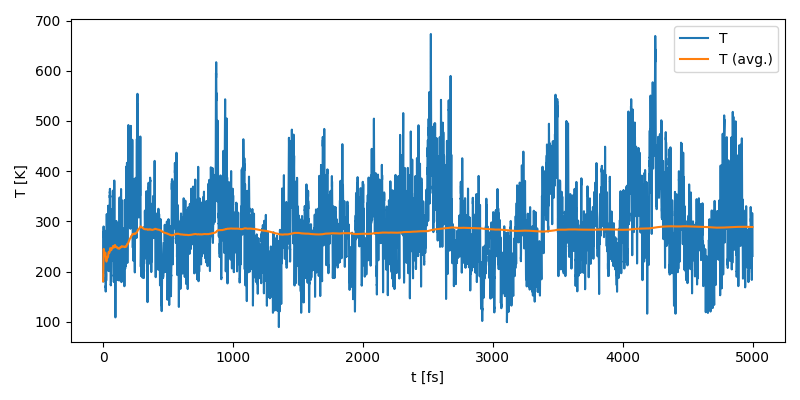

In [37]:
rpmd_data = HDF5Loader(rpmd_log_file, skip_initial=25000)
plot_temperature(rpmd_data)

Finally, we can compute the power spectrum and compare it to its classical counterpart:

INFO:root:Spectral resolutions:        4.072 [cm^-1]
INFO:root:Spectral range:          83391.024 [cm^-1]


<IPython.core.display.Javascript object>


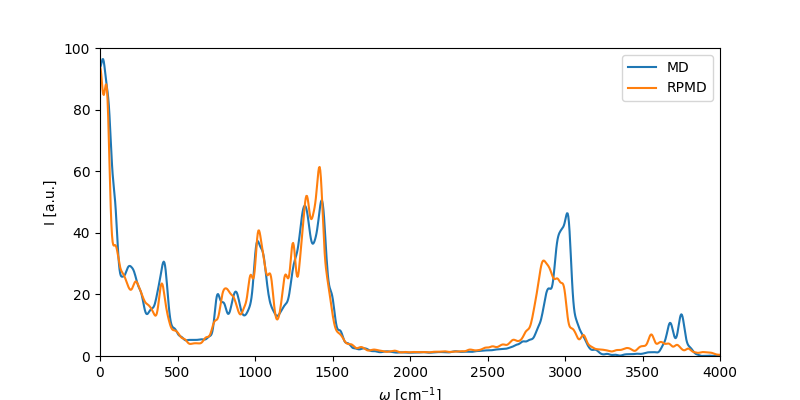

In [38]:
# Initialize the spectrum
rpmd_resolution = int(time_step / rpmd_time_step * 2048) # bring to same spectral resolution as MD
rpmd_spectrum = PowerSpectrum(rpmd_data, resolution=rpmd_resolution)

# Compute the spectrum for the first molecule (default)
rpmd_spectrum.compute_spectrum(molecule_idx=0)

# Get frequencies and intensities
rpmd_frequencies, rpmd_intensities = rpmd_spectrum.get_spectrum()

# Plot the spectrum
plt.figure(figsize=(8, 4))
plt.plot(frequencies, intensities, label="MD")
plt.plot(rpmd_frequencies, rpmd_intensities, label="RPMD")
plt.xlim(0, 4000)
plt.ylim(0, 100)
plt.ylabel("I [a.u.]")
plt.xlabel("$\omega$ [cm$^{-1}$]")
plt.legend()
plt.show()

One problem of purely classical simulations can be observed in the high frequency regions of the MD spectrum.
Peaks are shifted towards higher wave numbers compared to the expected [experimental values](https://chem.libretexts.org/Ancillary_Materials/Reference/Reference_Tables/Spectroscopic_Parameters/Infrared_Spectroscopy_Absorption_Table),
e.g. 3100&thinsp;cm<sup>-1</sup> vs. 2900&thinsp;cm<sup>-1</sup> for the CH vibrations.
The inclusion of nuclear quantum effects via RPMD shifts these bands towards lower frequencies, leading to an improved agreement with experiment.

## Using the command line interface and config files

While setting up simulations in the way described above can be useful for testing and developing new approaches, it can grow tedious for routine simulations.
Because of this, SchNetPack provides the script `spkmd` to quickly set up MD simulations using a combination of the `hydra` command line interface (CLI) and predefined config files.
The latter can be found in `src/schnetpack/md/md_configs`.

In the following, we will give a short introduction on how to use the CLI and/or config files for performing simulations with `spkmd`.

### Basic command line input

The inputs which need to be provided for every `spkmd` run are:

- a simulation directory (`simulation_dir`)
- the initial molecular geometry in an ASE readable format (`system.molecule_file`)
- the path to a trained ML model (`calculator.model_file`)
- and the cutoff used in the neighbor list (`calculator.neighbor_list.cutoff`)

Assuming the model and structure file used above are present in the local directory, the  command line call would be:

    spkmd simulation_dir=mdtut_cli system.molecule_file=md_ethanol.xyz calculator.model_file=md_ethanol.model calculator.neighbor_list.cutoff=5.0

This command would carry out a classical NVE simulation in the `mdtut_cli` directory, running on the GPU for 1&thinsp;000&thinsp;000 steps, using a time step of 0.5 fs (the device can be switched by appending `device=cpu`).
It would further automatically set up checkpointing and logging to HDF5 and tensorboard as described above.

Running the command will print out the full config used for the simulation:
```
⚙ Running with the following config:
├── device
│   └── cuda
├── precision
│   └── 32
├── seed
│   └── None
├── simulation_dir
│   └── mdtut_cli
├── overwrite
│   └── False
├── restart
│   └── None
├── calculator
│   └── neighbor_list:
│         _target_: schnetpack.md.neighborlist_md.NeighborListMD
│         cutoff: 5.0
│         cutoff_shell: 2.0
│         requires_triples: false
│         base_nbl: schnetpack.transform.ASENeighborList
│         collate_fn: schnetpack.data.loader._atoms_collate_fn
│       _target_: schnetpack.md.calculators.SchNetPackCalculator
│       required_properties:
│       - energy
│       - forces
│       model_file: md_ethanol.model
│       force_label: forces
│       energy_units: kcal / mol
│       position_units: Angstrom
│       energy_label: energy
│       stress_label: null
│       script_model: false
├── system
│   └── initializer:
│         _target_: schnetpack.md.UniformInit
│         temperature: 300
│         remove_center_of_mass: true
│         remove_translation: true
│         remove_rotation: true
│         wrap_positions: false
│       molecule_file: md_ethanol.xyz
│       load_system_state: null
│       n_replicas: 1
│       position_unit_input: Angstrom
│       mass_unit_input: 1.0
├── dynamics
│   └── integrator:
│         _target_: schnetpack.md.integrators.VelocityVerlet
│         time_step: 0.5
│       n_steps: 1000000
│       thermostat: null
│       barostat: null
│       progress: true
│       simulation_hooks: []
└── callbacks
    └── checkpoint:
          _target_: schnetpack.md.simulation_hooks.Checkpoint
          checkpoint_file: checkpoint.chk
          every_n_steps: 10
        hdf5:
          _target_: schnetpack.md.simulation_hooks.FileLogger
          filename: simulation.hdf5
          buffer_size: 100
          data_streams:
          - _target_: schnetpack.md.simulation_hooks.MoleculeStream
            store_velocities: true
          - _target_: schnetpack.md.simulation_hooks.PropertyStream
            target_properties:
            - energy
          every_n_steps: 1
          precision: 32
        tensorboard:
          _target_: schnetpack.md.simulation_hooks.TensorBoardLogger
          log_file: logs
          properties:
          - energy
          - temperature
          every_n_steps: 10
```

As can be seen, the config is structured into different blocks, which correspond to the `calculator`, `system`, `dynamics` and `callbacks` structure introduced above.

### Customizing the simulation

In the following, we will describe how to configure a simulation by overwriting existing configurations and loading additional settings from predefined configs.
As an example, we will reproduce the MD run using the Langevin thermostat from above.

For this, we first need to change the number of simulation steps from 1&thinsp;000&\thinsp;000 to 20&thinsp;000.
Since the corresponding config entry is `n_steps` in the `dynamics` block, this can be done by adding `dynamics.n_steps=20000` to the command line.
Changing other existing config entries can be done in a similar manner.

We also need to add a thermostat to the simulation.
For convenience, several thermostats are preconfigured in `src/schnetpack/md/md_configs/dynamics/thermostat`.
To load the Langevin thermostat (`langevin`), we add the `+dynamics/thermostat=langevin` option to the command line call:

    spkmd simulation_dir=mdtut_cli system.molecule_file=md_ethanol.xyz calculator.model_file=md_ethanol.model calculator.neighbor_list.cutoff=5.0 dynamics.n_steps=20000 +dynamics/thermostat=langevin

The simulation config will now show a different entry for the `thermostat` option in the `dynamics` block:
```
│       thermostat:
│         _target_: schnetpack.md.simulation_hooks.LangevinThermostat
│         temperature_bath: 300.0
│         time_constant: 100.0
```
Here, the thermostat temperature is already set to the desired 300 K.
Similar to the simulation steps, it could e.g. be changed to 500 K with the option `dynamics.thermostat.temperature_bath=500`

We could also easily use another preconfigured thermostat (e.g. Nos&eacute;--Hover chains, `+dynamic/thermostat=nhc`) or add a barostat if we wanted to perform a constant pressure simulation (e.g. an isotropic Nos&eacute;--Hoover barostat, `+dynamic/barostat=nhc_iso`).
A similar syntax can further be used to modify the neighbor list in the calculator (e.g. to use a torch based implementation add `calculator/neighbor_list=torch`)
You might have noticed, that some modifications use a `+` where others do not.
A general rule is, that the `+` is required if the corresponding entry did not exists before or was empty (e.g. `thermostat: null` in the very first config).

Let us have a look at the RPMD simulation above.
To reproduce it via the CLI, we have to:

- switch the integrator from Velocity Verlet to a suitable RPMD integrator (`dynamics/integrator=rpmd`)
- set the number of beads/replicas (`system.n_replicas=4`)
- add a suitable thermostat (`+dynamics/thermostat=pile_local`)
- and change the number of steps to 50000 (`dynamics.n_steps=50000`)

We should also change the simulation directory.
The corresponding command would be

    spkmd simulation_dir=mdtut_cli_rpmd system.molecule_file=md_ethanol.xyz calculator.model_file=md_ethanol.model calculator.neighbor_list.cutoff=5.0 dynamics/integrator=rpmd system.n_replicas=4 +dynamics/thermostat=pile_local dynamics.n_steps=50000

A quick look at the `dynamics.integrator` block confirms that it has changed and also uses reasonable defaults for the time step and bead temperature:
```
│   └── integrator:
│         _target_: schnetpack.md.integrators.RingPolymer
│         time_step: 0.2
│         temperature: 300.0
```

### Running simulations from config files

In some cases, it can be useful to run simulations using config files as input.
These can for example be created using the `spkmd` CLI and then fine-tuned to suit one's needs.

Full configs for the MD can either be found in the simulation directories (`mdtut_cli/.hydra/config.yaml`) or generated with `spkmd` by adding the `--cfg job` option and redirecting the output to a `yaml` file. This can then be saved, modified and used to run simulations.

The config file for the MD with the Langevin thermostat would look something like this:
```yaml
calculator:
  neighbor_list:
    _target_: schnetpack.md.neighborlist_md.NeighborListMD
    cutoff: 5.0
    cutoff_shell: 2.0
    requires_triples: false
    base_nbl: schnetpack.transform.ASENeighborList
    collate_fn: schnetpack.data.loader._atoms_collate_fn
  _target_: schnetpack.md.calculators.SchNetPackCalculator
  required_properties:
  - energy
  - forces
  model_file: md_ethanol.model
  force_label: forces
  energy_units: kcal / mol
  position_units: Angstrom
  energy_label: energy
  stress_label: null
  script_model: false
system:
  initializer:
    _target_: schnetpack.md.UniformInit
    temperature: 300
    remove_center_of_mass: true
    remove_translation: true
    remove_rotation: true
    wrap_positions: false
  molecule_file: md_ethanol.xyz
  load_system_state: null
  n_replicas: 1
  position_unit_input: Angstrom
  mass_unit_input: 1.0
dynamics:
  integrator:
    _target_: schnetpack.md.integrators.VelocityVerlet
    time_step: 0.5
  n_steps: 20000
  thermostat:
    _target_: schnetpack.md.simulation_hooks.LangevinThermostat
    temperature_bath: 300.0
    time_constant: 100.0
  barostat: null
  progress: true
  simulation_hooks: []
callbacks:
  checkpoint:
    _target_: schnetpack.md.simulation_hooks.Checkpoint
    checkpoint_file: checkpoint.chk
    every_n_steps: 10
  hdf5:
    _target_: schnetpack.md.simulation_hooks.FileLogger
    filename: simulation.hdf5
    buffer_size: 100
    data_streams:
    - _target_: schnetpack.md.simulation_hooks.MoleculeStream
      store_velocities: true
    - _target_: schnetpack.md.simulation_hooks.PropertyStream
      target_properties:
      - energy
    every_n_steps: 1
    precision: ${precision}
  tensorboard:
    _target_: schnetpack.md.simulation_hooks.TensorBoardLogger
    log_file: logs
    properties:
    - energy
    - temperature
    every_n_steps: 10
device: cuda
precision: 32
seed: null
simulation_dir: mdtut_cli
overwrite: false
restart: null
```

Settings can then be changed by modifying the corresponding entries.
E.g. to increase the simulation temperature to 500 K, the `temperature_bath` entry in the `thermostat` block can be changed to 500.

Assuming the config file is e.g. stored in `md_input_langevin.yaml`, it can be used to run the MD with the command:

    spkmd simulation_dir=md_from_config load_config=md_input_langevin.yaml

The `simulation_dir` option is still required, due to how hydra resolves configs.
Any `simulation_dir` entries in the provided config file will be ignored.

Since the `hydra` parser operates on classes from python modules, they can also be easily adapted to integrate external modules, e.g. custom calculators for simulations.

## Summary

In this tutorial, we have given a basic introduction to the structure and functionality of the MD package in SchNetPack.
After setting up a standard MD simulation, we have explored how to use simulation hooks to control simulations in a modular way.
We have shown how to extract data from the HDF5 files generated during MD and how available functions can be used to compute dynamic quantities, such as power spectra.
This was followed by a short example of using more advanced simulation techniques in the form of RPMD.
Finally, a short introduction to the `spkmd` script and the use of `hydra` configs was given.